In [150]:
import utils

import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

## Day 6: Guard Gallivant

[#](https://adventofcode.com/2024/day/6) We have a 2d grid, with some impassable bits marked "#" on it. A guard is patrolling this grid - we need to map out his path.

* `<>^v` marks the direction guard is facing
* guard moves forward, unless an obstable, in which case turns right 90 degrees.

How many **distinct points** on the grid does the guard visit before leaving the grid?

In [111]:
sample_input: str = """....#.....
.........#
..........
..#.......
.......#..
..........
.#..^.....
........#.
#.........
......#..."""

puzzle_input = utils.get_input(6, splitlines=False)

In [175]:
def parse_input(input_str=sample_input, debug=False):
    """returns 2d grid"""
    # return [
    #     [0 if char == "." else char for char in row]
    #     for row in input_str.strip().splitlines()
    # ]
    return [[char for char in row] for row in input_str.strip().splitlines()]


grid = parse_input(sample_input, True)
grid

[['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.', '.', '#'],
 ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '#', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '#', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '#', '.', '.', '^', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.', '#', '.'],
 ['#', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '#', '.', '.', '.']]

Implementing this one function at a time... makes the code a bit long, but for my own sanity here goes...

In [176]:
def find_guard(grid=grid):
    """returns the guards starting position, assumes facing north"""
    assert len(grid) > 0
    for y, row in enumerate(grid):
        try:
            x = row.index("^")
            return row[x], (x, y)
        except:
            pass


def turn_guard(dir, turn="right"):
    """takes in current dir and turn dir, returns new dir"""
    turns = ("^", ">", "v", "<")
    idx = turns.index(dir)
    match turn:
        case "right":
            return turns[(idx + 1) % 4]
        case "left":
            return turns[(idx - 1) % 4]


dir, pos = find_guard(grid)
print(f"Starting: {dir}, {pos}, testing turns:")
for _ in range(4):
    dir = turn_guard(dir)
    print(dir)

Starting: ^, (4, 6), testing turns:
>
v
<
^


In [177]:
def move_guard(dir, pos, grid=grid, turn="right"):
    x, y = pos

    match dir:
        case "^":
            y -= 1
        case "v":
            y += 1
        case ">":
            x += 1
        case "<":
            x -= 1
        case _:
            print(f"Direction {dir} not accounted for")

    # If we're off grid, return immediately without turning
    if y < 0 or y >= len(grid) or x < 0 or x >= len(grid[0]):
        return dir, (x, y)

    try:
        if grid[y][x] == "#":
            # return new dir and same pos
            return turn_guard(dir, turn), pos
    except:
        print(f"moved off grid at {x=}, {y=}")
        return dir, (x, y)  # returns new pos

    # is this line redundant?
    return dir, (x, y)  # returns new pos


for i in range(3):
    dir, pos = move_guard(dir, pos)
    print(f"{i}, {dir} {pos}")

0, ^ (4, 5)
1, ^ (4, 4)
2, ^ (4, 3)


In [178]:
def solve(inp: str = sample_input, obstacle=False, debug: bool = False):

    grid = parse_input(inp)
    dir, pos = find_guard(grid)

    # add new obstacle to grid if passed in
    if obstacle:
        grid[obstacle[1]][obstacle[0]] = "#"

    x, y = pos
    X, Y = len(grid[0]), len(grid)  # grid size
    if debug:
        print(f"Grid size: {X=}, {Y=}, guard at {pos=}")

    visited = []  # records position at every timestamp
    state_history = set()

    i = 0
    while 0 <= x < X and 0 <= y < Y:  # keep moving while on grid

        visited.append(pos)

        dir, pos = move_guard(dir, pos, grid)
        x, y = pos

        if debug:
            print(f"{i:6} {pos=}, {dir}")
            pass
        i += 1

        # test for loops for part 2
        state = (pos, dir)
        if state in state_history:
            print(f"Loop detected at {i=}, {pos=}, {dir=}")
            # print(f"Unique positions visited: {len(seen)}")
            return False

        state_history.add(state)

    ans = len(set(visited))

    return {"result": ans, "visited": visited}


assert solve(sample_input)["result"] == 41  # sample ans check

results = solve(puzzle_input, debug=False)
print(f"Part 1: {results["result"]}")

Part 1: 5153


# Plotting...

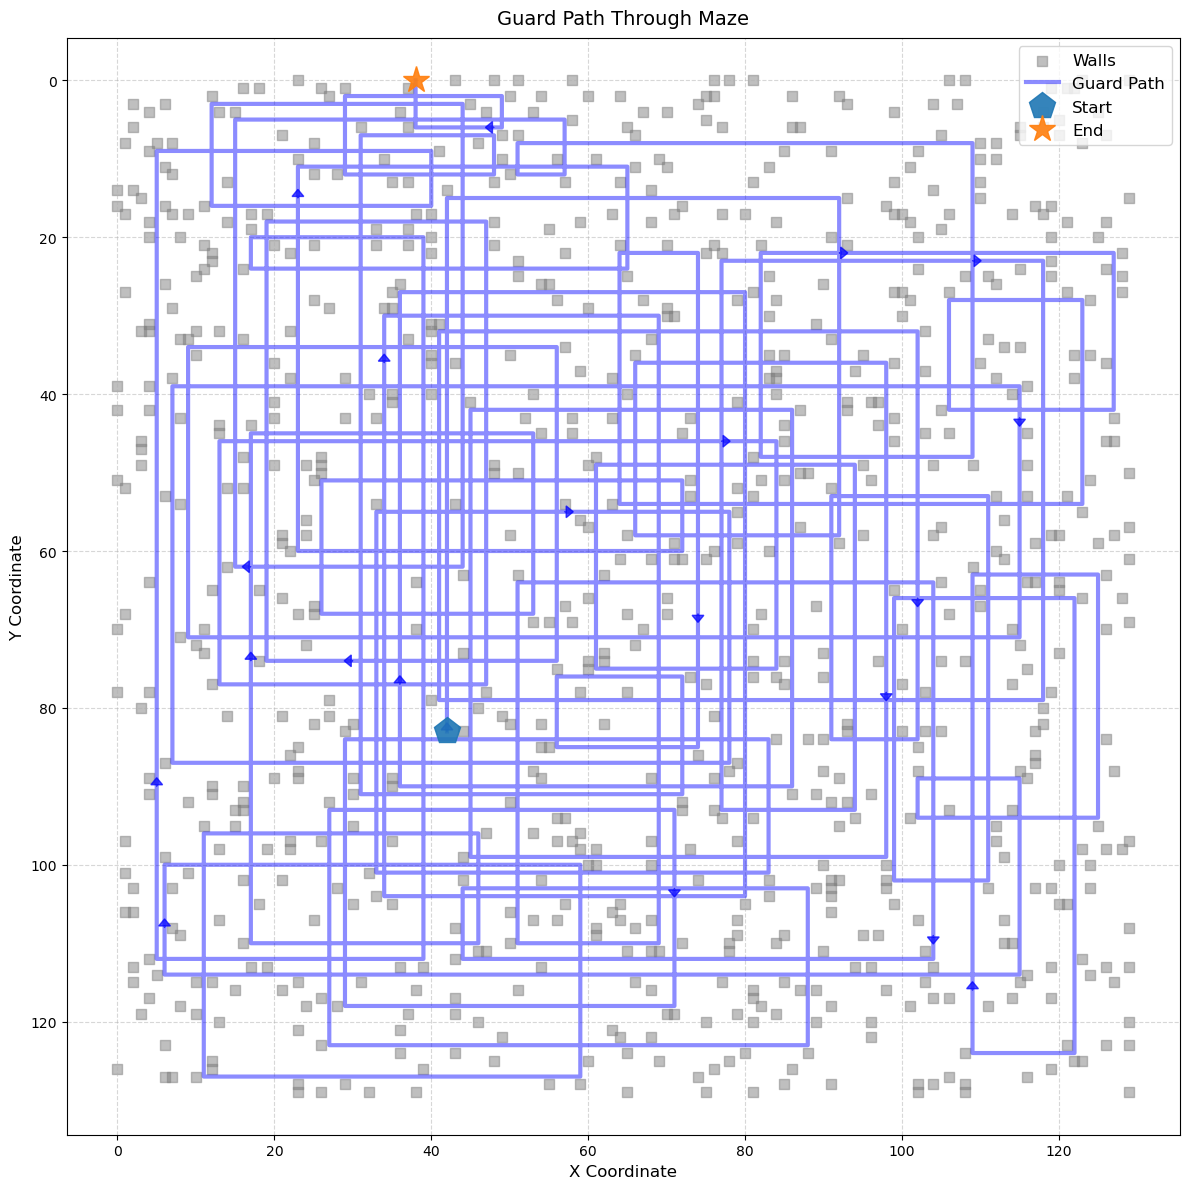

In [201]:
inp = puzzle_input
grid = parse_input(inp)
results = solve(puzzle_input, debug=False)
dir, pos = find_guard(grid)
x, y = pos
X, Y = len(grid[0]), len(grid)

# Get wall positions
walls = [(x, y) for y in range(Y) for x in range(X) if grid[y][x] == "#"]
wall_x, wall_y = zip(*walls)

plt.figure(figsize=(12, 12))

# Plot walls
plt.scatter(wall_x, wall_y, c="gray", marker="s", s=50, alpha=0.5, label="Walls")

# Plot path with increased opacity
v = results["visited"]
x_coords, y_coords = zip(*v)
plt.plot(x_coords, y_coords, "b-", linewidth=3, alpha=0.45, label="Guard Path")
plt.plot(x_coords[0], y_coords[0], "p", label="Start", markersize=20, alpha=0.9)
plt.plot(x_coords[-1], y_coords[-1], "*", label="End", markersize=20, alpha=0.9)

# Add arrows to show direction
step = max(1, len(x_coords) // 20)
for i in range(0, len(x_coords) - 1, step):
    plt.arrow(
        x_coords[i],
        y_coords[i],
        (x_coords[i + 1] - x_coords[i]) * 0.2,
        (y_coords[i + 1] - y_coords[i]) * 0.2,
        head_width=1.5,
        head_length=0.9,
        fc="blue",
        ec="blue",
        alpha=0.7,
    )

plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Guard Path Through Maze", fontsize=14, pad=10)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.legend(loc="upper right", fontsize=12)

# Set axis limits based on grid size
plt.xlim(-1, X + 1)
plt.ylim(Y + 1, -1)  # Inverted y-axis with padding

# Make it square to preserve proportions
plt.axis("equal")

plt.tight_layout()
plt.show()

## Part 2

The guard covers too large an area, so we want to place one obstruction which gets the guard stuck in a loop. We want to know all the possibly positions where placing one obstacle causes a loop. Return the number of loop causing positions.

This is easy after part 1 - we just need to modify 1 to track states and return False if in a loop. 


In [ ]:
inp = puzzle_input
results = solve(inp)
print(f"Number of unique points: {results["result"]}")

# very important step! else I was getting too high a ans
points_visited = set(results["visited"][1:])  # ignore start position

loopy = 0

for pos in points_visited:
    if not solve(inp, pos):
        loopy += 1

f"{loopy} loops found"

5153
Loop detected at i=4107, pos=(47, 45), dir='v'
Loop detected at i=5593, pos=(51, 91), dir='^'
Loop detected at i=3446, pos=(63, 55), dir='>'
Loop detected at i=2114, pos=(92, 15), dir='v'
Loop detected at i=4075, pos=(44, 112), dir='^'
Loop detected at i=4211, pos=(53, 51), dir='v'
Loop detected at i=5770, pos=(44, 3), dir='v'
Loop detected at i=3300, pos=(95, 57), dir='<'
Loop detected at i=5708, pos=(64, 104), dir='<'
Loop detected at i=2510, pos=(47, 77), dir='<'
Loop detected at i=4181, pos=(91, 73), dir='^'
Loop detected at i=2779, pos=(108, 1), dir='>'
Loop detected at i=2712, pos=(64, 104), dir='<'
Loop detected at i=5055, pos=(5, 39), dir='^'
Loop detected at i=5703, pos=(44, 112), dir='^'
Loop detected at i=4736, pos=(17, 48), dir='^'
Loop detected at i=3135, pos=(92, 32), dir='v'
Loop detected at i=5153, pos=(57, 12), dir='<'
Loop detected at i=5642, pos=(86, 90), dir='<'
Loop detected at i=5375, pos=(98, 36), dir='v'
Loop detected at i=1934, pos=(78, 87), dir='v'
Loop d

'1711 loops found'